In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots

from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
def load_data():
    dataset = h5py.File(f'./capybara dataset/capybara_dataset.h5', "r")
    data_x = np.array(dataset["x"][:]) # train set features.
    data_y = np.array(dataset["y"][:]) # train set labels.

    classes = np.array(dataset["list_classes"][:]) # the list of classes
    
    data_y = data_y.reshape((data_y.shape[0], 1))
    
    return data_x, data_y, classes

In [3]:
capybara_x, capybara_y, classes = load_data()
print ("capybara_x's shape: " + str(capybara_x.shape))
print ("capybara_y's shape: " + str(capybara_y.shape))

capybara_x's shape: (500, 64, 64, 3)
capybara_y's shape: (500, 1)


y = 1. It is a capybara picture.


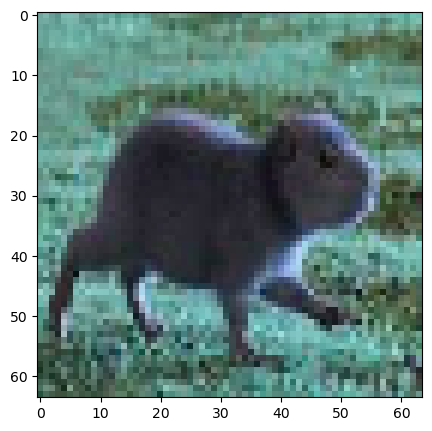

In [4]:
# Example pictures
index = 12
plt.imshow(capybara_x[index])
print ("y = " + str(capybara_y[index,0]) + ". It is a " + classes[capybara_y[index,0]].decode("utf-8") +  " picture.")

y = 0. It is a not capybara picture.


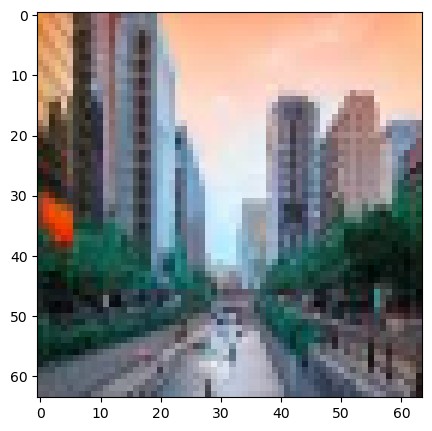

In [5]:
index = 400
plt.imshow(capybara_x[index])
print ("y = " + str(capybara_y[index,0]) + ". It is a " + classes[capybara_y[index,0]].decode("utf-8") +  " picture.")

In [6]:
# Define the test proportion.
test_proportion = 0.2

# Split data into train and test sets.
train_x, test_x, train_y, test_y = train_test_split(capybara_x, capybara_y, test_size = test_proportion, shuffle = True, random_state=42)

In [7]:
# Explore the dataset.
m_train = train_x.shape[0]
num_px = train_x.shape[1]
m_test = test_x.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x shape: " + str(train_x.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x shape: " + str(test_x.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 400
Number of testing examples: 100
Each image is of size: (64, 64, 3)
train_x shape: (400, 64, 64, 3)
train_y shape: (400, 1)
test_x shape: (100, 64, 64, 3)
test_y shape: (100, 1)


In [8]:
# Reshape the training and test data. 
train_x = train_x.reshape(train_x.shape[0], -1).T
test_x = test_x.reshape(test_x.shape[0], -1).T

# Scale the data to have feature values between 0 and 1.
train_x = train_x/255.
test_x = test_x/255.

train_y, test_y = train_y.T, test_y.T

print ("train_x shape: " + str(train_x.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x shape: " + str(test_x.shape))
print ("test_y shape: " + str(test_y.shape))

train_x shape: (12288, 400)
train_y shape: (1, 400)
test_x shape: (12288, 100)
test_y shape: (1, 100)


In [9]:
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy.
    
    Arguments:
    Z -- numpy array of any shape.
    
    Returns:
    A -- output of sigmoid(z), same shape as Z.
    cache -- returns Z as well, useful during backpropagation.
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single sigmoid unit.

    Arguments:
    dA -- post-activation gradient, of any shape.
    cache -- 'Z' where we store for computing backward propagation efficiently.

    Returns:
    dZ -- Gradient of the cost with respect to Z.
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def relu(Z):
    """
    Implement the ReLU function.

    Arguments:
    Z -- Output of the linear layer, of any shape.

    Returns:
    A -- Post-activation parameter, of the same shape as Z.
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently.
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

def relu_backward(dA, cache):
    """
    Implement the backward propagation for a single ReLU unit.

    Arguments:
    dA -- post-activation gradient, of any shape.
    cache -- 'Z' where we store for computing backward propagation efficiently.

    Returns:
    dZ -- Gradient of the cost with respect to Z.
    """
    
    Z = cache
    dZ = np.array(dA, copy=True)
     
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [10]:
class LLayerModel():
    """
    A multilayer fully-connected neural network with ReLU activations in the hidden layers and a sigmoid activation for the output layer.
    ...

    Attributes
    ----------
    layers_dims : integer list
        dimensions of the layers
    parameters : dict
        family name of the person
    num_params : int
        number of parameters of the network

    """
    def __init__(self, layers_dims):
        """
        Construct all the necessary attributes.
        
        Arguments:
        layer_dims -- python array (list) containing the dimensions of each layer in our network
        
        """
        self.layers_dims = layers_dims
        self.parameters = self.initialize_parameters()
        self.num_params = len(self.parameters)
        self.costs = []  
        
    def initialize_parameters(self):
        """
        Arguments:
        layer_dims -- python array (list) containing the dimensions of each layer in our network

        Returns:
        parameters -- python dictionary containing parameters "W1", "b1", ..., "WL", "bL":
                        Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                        bl -- bias vector of shape (layer_dims[l], 1)
        """

        np.random.seed(42)
        parameters = {}
        L = len(self.layers_dims) # number of layers in the network

        for l in range(1, L):

            parameters['W' + str(l)] = np.random.randn(self.layers_dims[l], self.layers_dims[l-1]) * 0.1
            parameters['b' + str(l)] = np.zeros((self.layers_dims[l], 1))

            assert(parameters['W' + str(l)].shape == (self.layers_dims[l], self.layers_dims[l - 1]))
            assert(parameters['b' + str(l)].shape == (self.layers_dims[l], 1))


        return parameters
        
    def linear_forward(self, A, W, b):
        """
        Implement the linear part of a layer's forward propagation.

        Arguments:
        A -- activations from previous layer (or input data): (size of previous layer, number of examples)
        W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
        b -- bias vector, numpy array of shape (size of the current layer, 1)

        Returns:
        Z -- the input of the activation function, also called pre-activation parameter 
        cache -- a python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
        """
        
        Z = W @ A + b
        cache = (A, W, b)

        return Z, cache
        
    def linear_activation_forward(self, A_prev, W, b, activation):
        """
        Implement the forward propagation for the LINEAR->ACTIVATION layer.

        Arguments:
        A_prev -- activations from previous layer (or input data): (size of previous layer, number of examples)
        W -- weights matrix: numpy array of shape (size of current layer, size of previous layer)
        b -- bias vector, numpy array of shape (size of the current layer, 1)
        activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

        Returns:
        A -- the output of the activation function, also called the post-activation value 
        cache -- a python tuple containing "linear_cache" and "activation_cache";
                 stored for computing the backward pass efficiently
        """

        Z, linear_cache = self.linear_forward(A_prev, W, b)
        if activation == "sigmoid":  
            A, activation_cache = sigmoid(Z)
        elif activation == "relu":
            A, activation_cache = relu(Z)

        cache = (linear_cache, activation_cache)

        return A, cache
        
    def forward(self, X):
        """
        Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation

        Arguments:
        X -- data, numpy array of shape (input size, number of examples)
        parameters -- output of initialize_parameters_deep()

        Returns:
        AL -- activation value from the output (last) layer
        caches -- list of caches containing:
                    every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
        """

        caches = []
        A = X
        L = self.num_params // 2 # number of layers in the neural network

        # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
        for l in range(1, self.num_params // 2):
            A_prev = A 
            #(≈ 2 lines of code)
            A, cache = self.linear_activation_forward(A_prev, self.parameters['W'+str(l)], self.parameters['b'+str(l)], 'relu')
            caches.append(cache)

        # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
        AL, cache = self.linear_activation_forward(A, self.parameters['W'+str(L)], self.parameters['b'+str(L)], 'sigmoid')
        caches.append(cache)

        return AL, caches
        
    def compute_cost(self, AL, Y):
        """
        Implement the cost function defined by equation (7).

        Arguments:
        AL -- probability vector corresponding to label predictions, shape (1, number of examples)
        Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

        Returns:
        cost -- cross-entropy cost
        """

        m = Y.shape[1]

        # Compute loss from aL and y.
        cost = -(np.dot(Y,np.log(AL).T) + np.dot(1-Y,np.log(1-AL).T))/m
        cost = np.squeeze(cost)

        return cost
        
    def linear_backward(self, dZ, cache):
        """
        Implement the linear portion of backward propagation for a single layer (layer l)

        Arguments:
        dZ -- Gradient of the cost with respect to the linear output (of current layer l)
        cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

        Returns:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        db -- Gradient of the cost with respect to b (current layer l), same shape as b
        """
        A_prev, W, b = cache
        m = A_prev.shape[1]

        dW = np.dot(dZ, A_prev.T)/m
        db = np.mean(dZ, axis = 1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)

        return dA_prev, dW, db

    def linear_activation_backward(self, dA, cache, activation):
        """
        Implement the backward propagation for the LINEAR->ACTIVATION layer.

        Arguments:
        dA -- post-activation gradient for current layer l 
        cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
        activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

        Returns:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        db -- Gradient of the cost with respect to b (current layer l), same shape as b
        """
        linear_cache, activation_cache = cache

        if activation == "relu":

            dZ = relu_backward(dA, activation_cache)

        elif activation == "sigmoid":

            dZ = sigmoid_backward(dA, activation_cache)

        dA_prev, dW, db = self.linear_backward(dZ, linear_cache)

        return dA_prev, dW, db
        
    def backward(self, AL, Y, caches):
        """
        Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group

        Arguments:
        AL -- probability vector, output of the forward propagation (L_model_forward())
        Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
        caches -- list of caches containing:
                    every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                    the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])

        Returns:
        grads -- A dictionary with the gradients
                 grads["dA" + str(l)] = ... 
                 grads["dW" + str(l)] = ...
                 grads["db" + str(l)] = ... 
        """
        grads = {}
        L = len(caches) # the number of layers
        m = AL.shape[1]
        Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL

        # Initializing the backpropagation
        dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

        # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
        current_cache = caches[L-1]
        dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(dAL, current_cache, 'sigmoid')
        grads["dA" + str(L-1)] = dA_prev_temp
        grads["dW" + str(L)] = dW_temp
        grads["db" + str(L)] = db_temp

        # Loop from l=L-2 to l=0
        for l in reversed(range(L-1)):
            # lth layer: (RELU -> LINEAR) gradients.
            # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 
            current_cache = caches[l]
            dA_prev_temp, dW_temp, db_temp = self.linear_activation_backward(grads["dA" + str(l+1)], current_cache, 'relu')
            grads["dA" + str(l)] = dA_prev_temp
            grads["dW" + str(l + 1)] = dW_temp
            grads["db" + str(l + 1)] = db_temp
            
        return grads
        
    def update_parameters(self, grads, learning_rate):
        """
        Update parameters using gradient descent

        Arguments:
        params -- python dictionary containing parameters 
        grads -- python dictionary containing gradients, output of L_model_backward

        Returns:
        parameters -- python dictionary containing updated parameters 
                      parameters["W" + str(l)] = ... 
                      parameters["b" + str(l)] = ...
        """

        L = self.num_params // 2 # number of layers in the neural network

        # Update rule for each parameter.
        for l in range(L):
            self.parameters["W" + str(l+1)] -= learning_rate * grads["dW" + str(l+1)]
            self.parameters["b" + str(l+1)] -= learning_rate * grads["db" + str(l+1)]
        
    def train(self, X, Y, learning_rate = .1, num_iterations = 3000, print_cost=False):
        
        costs = []

        for i in range(0, num_iterations):

            # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
            AL, caches = self.forward(X)

            # Compute cost.
            cost = self.compute_cost(AL, Y)

            # Backward propagation.
            grads = self.backward(AL, Y, caches)    

            # Update parameters.
            self.update_parameters(grads, learning_rate)

            # Print the cost every 100 iterations
            if print_cost and i % 100 == 0 or i == num_iterations - 1:
                print(f'Cost after iteration {i}: {np.squeeze(cost): .8f}.')

            if i % 100 == 0 or i == num_iterations:
                costs.append(cost)
                
    def predict(self, X, y = None):
        """
        This function is used to predict the results of a  L-layer neural network.

        Arguments:
        X -- data set of examples you would like to label
        parameters -- parameters of the trained model

        Returns:
        p -- predictions for the given dataset X
        """

        m = X.shape[1]
        n = self.num_params // 2 # number of layers in the neural network
        p = np.zeros((1,m))

        # Forward propagation
        probas, caches = self.forward(X)
        
        # convert probas to 0/1 predictions
        for i in range(0, probas.shape[1]):
            if probas[0,i] > 0.5:
                p[0,i] = 1
            else:
                p[0,i] = 0
        if y is not None:
            #print results
            print("Accuracy: " + str(np.mean(p == y)))
        
        return p

In [11]:
layers_dims = [12288, 20, 10, 5, 1] #  4-layer model
model = LLayerModel(layers_dims)

In [12]:
model.train(train_x, train_y, learning_rate = .01, num_iterations = 10000, print_cost = True)

Cost after iteration 0:  0.69356117.
Cost after iteration 100:  0.69320161.
Cost after iteration 200:  0.69300381.
Cost after iteration 300:  0.69289901.
Cost after iteration 400:  0.69281308.
Cost after iteration 500:  0.69273167.
Cost after iteration 600:  0.69266068.
Cost after iteration 700:  0.69256443.
Cost after iteration 800:  0.69245821.
Cost after iteration 900:  0.69233867.
Cost after iteration 1000:  0.69214982.
Cost after iteration 1100:  0.69191355.
Cost after iteration 1200:  0.69166633.
Cost after iteration 1300:  0.69137985.
Cost after iteration 1400:  0.69105351.
Cost after iteration 1500:  0.69067711.
Cost after iteration 1600:  0.69018826.
Cost after iteration 1700:  0.68960798.
Cost after iteration 1800:  0.68882729.
Cost after iteration 1900:  0.68782120.
Cost after iteration 2000:  0.68647383.
Cost after iteration 2100:  0.68453529.
Cost after iteration 2200:  0.68160942.
Cost after iteration 2300:  0.67533163.
Cost after iteration 2400:  0.66304569.
Cost after i

In [13]:
pred_train = model.predict(train_x, train_y)

Accuracy: 1.0


In [14]:
pred_test = model.predict(test_x, test_y)

Accuracy: 0.67


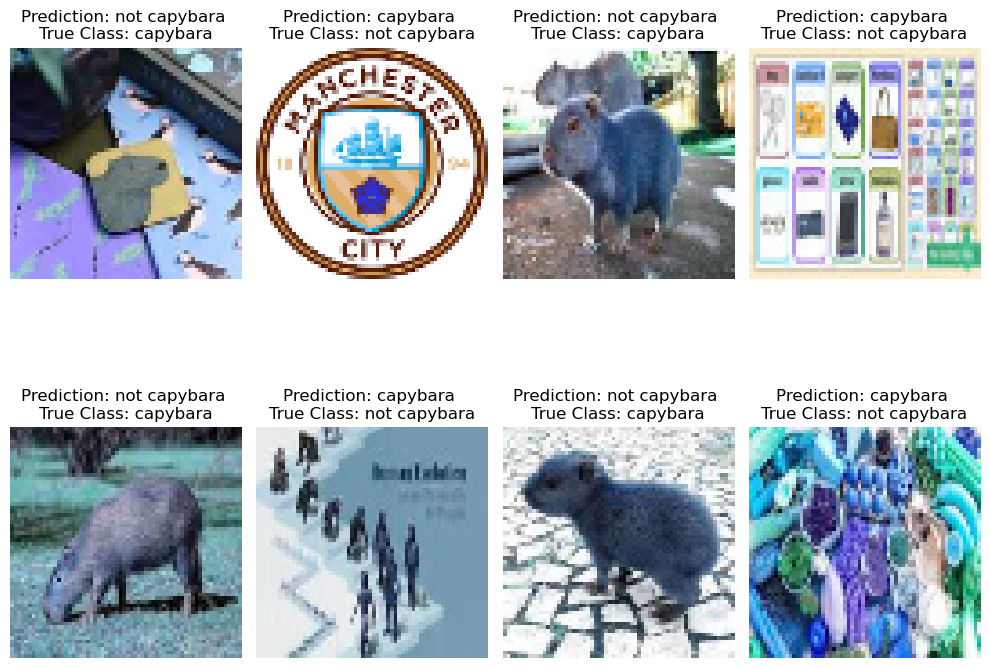

In [15]:
def plot_mislabeled_images(classes, X, y, predictions, num_images = None):
    """
    Plots mislabeled images where predictions and true labels differ.

    Arguments:
    classes (list): List of class labels.
    X (numpy.ndarray): Dataset.
    y (numpy.ndarray): True labels.
    predictions (numpy.ndarray): Predicted labels.
    num_images (int): Number of mislabeled images to display. If None, all mislabeled images are displayed.

    Returns:
    None
    """
    
    # Find mislabeled indices
    a = predictions + y
    mislabeled_indices = np.asarray(np.where(a == 1))[1]

    if num_images is None:
        num_images = len(mislabeled_indices)

    num_cols = 4  # Set the number of columns to 4

    # Calculate the number of rows needed based on the number of images and columns
    num_rows = (num_images + num_cols - 1) // num_cols

    fig, axs = plt.subplots(num_rows, num_cols, figsize = (10, 10))  # Adjust the figure size as needed
    fig.tight_layout()
    for i, index in enumerate(mislabeled_indices[:num_images]):
        row = i // num_cols
        col = i % num_cols
        # Shape of images is (height, width, channels)
        axs[row, col].imshow(X[:, index].reshape(64, 64, 3), interpolation = 'nearest')
        axs[row, col].axis('off')
        axs[row, col].set_title(f"Prediction: {classes[int(predictions[0, index])].decode('utf-8')} \nTrue Class: {classes[y[0, index]].decode('utf-8')}")

    plt.tight_layout()
    plt.show()

plot_mislabeled_images(classes, test_x, test_y, pred_test, num_images=8)